In [1]:
from src.models.SMC_Transformer.SMC_Transformer import SMC_Transformer
from src.data_provider.datasets import Dataset, CovidDataset, StandardizedDataset
from src.utils.utils_train import CustomSchedule
import os
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 1. Loading the Dataset
Energy consumption dataset from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
* **gathers 10-min measurements of household appliances energy consumption (20 first features)**, coupled with local meteorological data (8 last features). 
* **The time-series forecasting task is to predict the first 20 features, given as input data the 28 features**. A window of observations of 12 time steps is considered to predict the next series of observations (this corresponds to a 2-hours window of observations. 

In [2]:
# Load energy dataset
dataset = StandardizedDataset(data_path="data/energy_vm5", BUFFER_SIZE=50, BATCH_SIZE=32,
                                      name="energy", target_features=list(range(20)), max_samples=None)
train_data, val_data, test_data = dataset.get_datasets()
print('num samples in test dataset: {}'.format(test_data.shape[0]))
print('number of timeteps: {}'.format(train_data.shape[1] - 1))
print('number of input features: {}'.format(train_data.shape[-1]))
print('number of target features: {}'.format(len(dataset.target_features)))
_, _, test_dataset = dataset.data_to_dataset(train_data=train_data,val_data=val_data,test_data=test_data,
                                                                                    num_dim=4)

num samples in test dataset: 2959
number of timeteps: 12
number of input features: 28
number of target features: 20


### 2. Load the pretrained SMC Transformer on the energy dataset
* SMC Transformer with 10 particles, with one layer and one head, and with d_model = 32, trained during 50 epochs.

In [3]:
# Load Trained SMC Transformer on energy dataset: 
smc_transformer = SMC_Transformer(d_model=32,
                                               output_size=20,
                                               seq_len=12,
                                               full_model=True,
                                               dff=32,
                                               maximum_position_encoding=50,
                                               attn_window=None, num_layers=1, num_heads=1)
lr = CustomSchedule(32)
optimizer = tf.keras.optimizers.Adam(lr,
                                                  beta_1=0.9,
                                                  beta_2=0.98,
                                                  epsilon=1e-9)
ckpt = tf.train.Checkpoint(transformer=smc_transformer,
                                   optimizer=optimizer)
model_path = "output/exp_energy/smc_t_d32_p10/1/"
smc_T_ckpt_path = os.path.join(model_path, "checkpoints/SMC_transformer_1")
ckpt_manager = tf.train.CheckpointManager(ckpt, smc_T_ckpt_path, max_to_keep=50)
# if a checkpoint exists, restore the latest checkpoint.
def restoring_checkpoint(ckpt_manager):
    if ckpt_manager.latest_checkpoint:
        ckpt_restored_path = ckpt_manager.latest_checkpoint
        ckpt_name = os.path.basename(ckpt_restored_path)
        _, ckpt_num = ckpt_name.split('-')
        start_epoch = int(ckpt_num)
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("checkpoint restored from {}".format(ckpt_manager.latest_checkpoint))
        return start_epoch
start_epoch = restoring_checkpoint(ckpt_manager=ckpt_manager)

with open(os.path.join(model_path, "sigmas_after_training.json")) as json_file:
    dict_json = json.load(json_file)
sigmas_after_training = {key: float(value) for key, value in dict_json.items()}
print("updating sigmas values with the latest ones...{}".format(dict_json))
dict_sigmas = {key: sigmas_after_training[key] for key in ['k', 'q', 'v', 'z']}
sigma_obs = sigmas_after_training["sigma_obs"]
smc_transformer.cell.add_SMC_parameters(dict_sigmas=dict_sigmas, sigma_obs=sigma_obs,
                                                         num_particles=10)

checkpoint restored from output/exp_energy/smc_t_d32_p10/1/checkpoints/SMC_transformer_1/ckpt-50
updating sigmas values with the latest ones...{'sigma_obs': '0.042718995', 'k': '0.4828556', 'q': '0.56588805', 'v': '0.12711526', 'z': '0.59875816'}


### 3. Inference task: multistep time-series forecasting outputting predictive distribution
On the test dataset, we feed the trained SMC Transformer the first 6 timesteps of sequence of observations, and ask the model to predict the next 6 timesteps. 

![MarineGEO circle logo](SMC_Transformer_inference.png)

In [4]:
def inference_multistep(smc_transformer, inputs, targets, future_input_features=None, past_len=6, future_len=6):
    '''
    Get the multi-step output (of size future_len) of a SMC Transformer 
    given a sequence of observations of length past_len. 
    INPUTS: 
    * smc_transformer: the trained model.
    * inputs: the input sequence of observations dim = (batch_size, past_len, 28)
    * targets: the target sequence of observations (for resampling): dim = (batch_size, future_len, 20)
    * future_input_features: the future sequence of INPUT FEATURES dim = (batch_size, future_len 8)
    * past_len = 6, future_len = 6
    OUTPUT: 
    * The predicted output particles for the future sequence of observations: 
    dim = (batch_size, num_particles=10, future_len, 20)
    '''
    P = smc_transformer.cell.num_particles # number of particles = 10
    sigma_obs = tf.math.sqrt(smc_transformer.cell.Sigma_obs) # learned standard deviation of observation model.
    smc_transformer.seq_len = past_len
    # stop resampling for future timesteps (no access to ground-truth)
    smc_transformer.cell.add_stop_resampling(past_len)
    for i in range(future_len+1):
        # Get P particles outputs of the SMC Transformer with shape (batch_size, num_particles=10, past_len=6, 20)
        (preds, _), _, _ = smc_transformer(inputs, targets)
        last_pred = preds[:,:,-1,:] # get the P predictions for the last timestep
        # sample P predicted observations for the target features using the observation model
        last_pred = last_pred + tf.random.normal(shape=last_pred.shape, stddev=sigma_obs) 
        if i == 0:
            inputs = tf.tile(inputs, multiples=[1,P,1,1])
            targets = tf.tile(targets, multiples=[1,P,1,1])
        if i < future_len:
            input_features = tf.tile(future_input_features[:,:,i,:], multiples=[1,P,1])
            # Add input_features to current predictions
            last_pred = tf.concat([last_pred, input_features], axis=-1)
            last_pred = tf.expand_dims(last_pred, axis=-2)
            # concatenate inputs and current predictions
            inputs = tf.concat([inputs, last_pred], axis=-2)
            targets = tf.concat([targets, tf.zeros(shape=(targets.shape[0], targets.shape[1], 1, targets.shape[-1]))], axis=-2) # dummy target (not used when resampling is stopped.)
            smc_transformer.seq_len += 1
    mean_preds = tf.reduce_mean(preds, axis=1)
    # get all preds particles for future timesteps 
    preds_future = preds[:,:,past_len:,:]
    return preds_future

In [5]:
def get_distrib_all_timesteps(preds, sigma_obs, P, N=100, len_future=6):
    '''
    From a sequence of M predicted observations, get an empirical distribution. 
    INPUTS: 
    * preds: P predicted observations = output of inference_multistep function: dim=(batch_size, P=10, future_len=6, 20)
    * sigma_obs = learned standard deviation for observation model.
    * P = number of particles
    * N = Number of samples to estimate the empirical distribution.
    OUTPUTS:
    Sequence of empirical distribution: dim = (batch_size, N, future_len, 20)
    '''
    distrib_future_timesteps = []
    for t in range(len_future):
        mean_NP = preds[:,:,t,:]
        emp_distrib = []
        for i in range(N):
            # sample a trajectory z_t^n with probability w_t^m
            ind_p = np.random.randint(0, P) 
            sampled_mean = mean_NP[:, ind_p, :]
            # sample an observation X_t^n from z_t^n with the observation model
            sample = sampled_mean + tf.random.normal(shape=sampled_mean.shape, stddev=sigma_obs) # get a predicted observation $X_{t+1}^n
            emp_distrib.append(sample)
        # Get the Empirical Distrib \hat{X}_{t+1}^N of shape (batch_size,N,1, num_target_features=20)
        emp_distrib = np.stack(emp_distrib, axis=0) 
        distrib_future_timesteps.append(emp_distrib)
    distrib_future_timesteps = np.stack(distrib_future_timesteps, axis=0) # shape (S,N_est,B,F)
    distrib_future_timesteps = np.transpose(distrib_future_timesteps, axes=[2,1,0,3]) # Empirical Distrib for all future timesteps of shape (batch_size,N,future_len,num_target_features)
    print('distrib future timesteps', distrib_future_timesteps.shape)
    return distrib_future_timesteps

In [6]:
def get_predictive_distribution_multistep(smc_transformer, inputs, targets, past_len=6, future_len=6, N=100):
        inp, tar = inputs[:, :, :past_len, :], targets[:, :, :past_len, :]
        future_input_features = inputs[:, :, past_len:, 20:] # 8 input features not predicted. 
        particles = inference_multistep(smc_transformer=smc_transformer, inputs=inp,
                                                        targets=tar, past_len=past_len,
                                                        future_len=future_len,
                                                        future_input_features=future_input_features)
        sigma_obs = tf.math.sqrt(smc_transformer.cell.Sigma_obs)
        distrib_per_timestep = get_distrib_all_timesteps(particles, sigma_obs=sigma_obs,
                                                             P=10,
                                                             N=100,
                                                             len_future=future_len)
        distrib_per_timestep = tf.constant(distrib_per_timestep, dtype=tf.float32)
        return distrib_per_timestep

In [78]:
distrib_multistep, all_inputs, all_targets = [], [], []
for (inputs, targets) in test_dataset:
    distrib_multistep_batch = get_predictive_distribution_multistep(smc_transformer=smc_transformer, inputs=inputs, targets=targets)
    distrib_multistep.append(distrib_multistep_batch)
    all_inputs.append(inputs)
    all_targets.append(targets)
    
distrib_multistep = tf.stack(distrib_multistep, axis=0)
distrib_multistep = tf.reshape(distrib_multistep, shape=(-1,distrib_multistep.shape[-3], distrib_multistep.shape[-2], distrib_multistep.shape[-1]))
all_inputs = tf.stack(all_inputs, axis=0)
all_inputs = tf.reshape(all_inputs, shape=(-1,all_inputs.shape[-2], all_inputs.shape[-1]))
all_targets = tf.stack(all_inputs, axis=0)
all_targets = tf.reshape(all_inputs, shape=(-1,all_inputs.shape[-2], all_inputs.shape[-1]))

distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100, 6, 20)
distrib future timesteps (32, 100,

In [80]:
print(distrib_multistep.shape)

(2944, 100, 6, 20)


### 4. Plotting the results on same test samples

In [ ]:
def plot_preds_targets(inputs, targets, predictive_distribution):
    if len(tf.shape(inputs)) == 3:
        inputs = tf.squeeze(inputs, axis=0)
        targets = tf.squeeze(targets, axis=0)
    inp = inputs[:, 0].numpy()
    sample = predictive_distribution[:, :, 0].numpy()  # (mc_samples, seq_len, 1)
    mean_pred = np.mean(sample, axis=0)
    x = np.linspace(1, 12, 12)
    xx = np.linspace(6, 12, 6)
    plt.plot(xx, mean_pred, 'red', lw=2, label='predictions for sample: {}'.format(index))
    plt.plot(x, inp, 'cyan', lw=2, label='ground-truth for sample: {}'.format(index))
    for i in range(sample.shape[0]):
        plt.scatter(xx, sample[i], c='orange')
    plt.legend(fontsize=10)
    plt.show()

2158


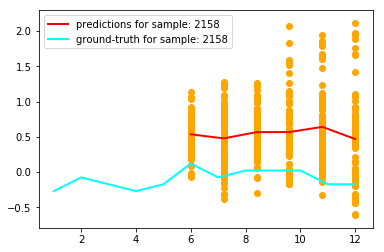

718


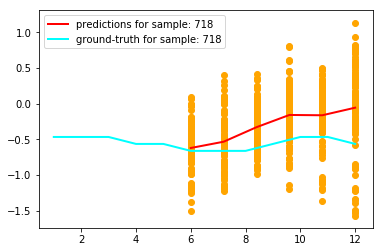

379


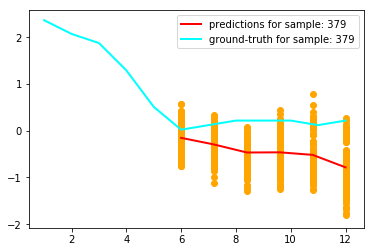

959


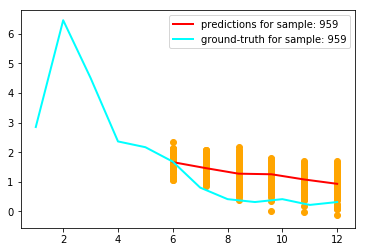

In [82]:
# select some test samples
indexes = [2158, 718, 379,959]
for index in indexes:
    print(index)
    distrib = distrib_multistep[index]
    inputs = all_inputs[index]
    targets = all_targets[index]
    plot_preds_targets(inputs=inputs, targets=targets, predictive_distribution=distrib)